In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
#
import os
import numpy as np
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
#
from sklearn.preprocessing import LabelEncoder
make_lb = LabelEncoder()
#
from sklearn.preprocessing import LabelBinarizer
lbb = LabelBinarizer()
#
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
#
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
#
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#
import pickle
#
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
# 
from sklearn.model_selection import GridSearchCV
#
from sklearn.linear_model import ElasticNetCV
#
from sklearn.linear_model import RidgeCV

---

## EDA

In [19]:
listings = pd.read_csv('listingscleanFINAL.csv')

In [20]:
listings.shape

(8059, 26)

In [21]:
listings.dropna(inplace=True)

In [22]:
listings.dropna(subset=['host_response_rate'], inplace=True)

In [23]:
listings.reset_index(drop=True, inplace=True)

In [24]:
listings['host_response_rate'] = listings['host_response_rate'].map(lambda x: x.replace('%', ''))
listings['price'] = listings['price'].map(lambda x: x.replace('$', ''))
listings['price'] = listings['price'].map(lambda x: x.replace(',', ''))

In [25]:
listings['price'] = listings['price'].astype('float')

In [26]:
# Refining the lists to only include valid prices
# For each type of response rate
prf_100 = []
for num in pr_100:
    if num > 0:
        prf_100.append(num)
prnf_100 = []
for num in prn_100:
    if num > 0:
        prnf_100.append(num)

NameError: name 'pr_100' is not defined

In [ ]:
# Two sample t test to see if the means are significantly different
stats.ttest_ind(prnf_100, prf_100, equal_var=True)

Cannot conclude that those who respond 100% of the time have higher prices than those who do not respond 100% of the time.

In [ ]:
listings = listings[['host_is_superhost', 'host_total_listings_count',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'guests_included', 'extra_people', 'minimum_nights',
       'number_of_reviews', 'review_scores_rating', 'instant_bookable']]

In [ ]:
listings.shape

----

### Final Cleaning and Analysis, Model Creation

In [27]:
listings2 = pd.read_csv('listingsclean2.csv')

In [28]:
listings2.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

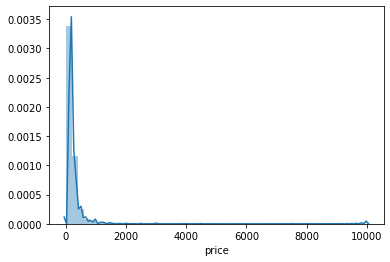

In [29]:
sns.distplot(listings2['price'])

In [ ]:
listings2['price'].describe()

In [30]:
listings2 = listings2[listings2['price'] <= 1000]

In [ ]:
listings2.isnull().sum()

In [ ]:
f, ax = plt.subplots(figsize=(16, 12))
matrix = np.triu(listings2.corr())
sns.heatmap(listings2.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

In [31]:
listings2 = listings2[listings2['minimum_nights'] < 59]

In [ ]:
listings2

In [ ]:
listings2.groupby('neighbourhood_cleansed')['price'].sum()

In [ ]:
rev = list(listings2.groupby('property_type')['price'].sum())
types = list(listings2.groupby('property_type')['price'].sum().keys())

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
chart = sns.barplot(x=types, y=rev)
chart.set_xticklabels(chart.get_xticklabels(),
                      rotation=45, horizontalalignment='right')

In [ ]:
listings2.price.sum()

In [ ]:
sns.distplot(listings2.price)

In [ ]:
(2818+1982+676+542)

In [ ]:
listings2.property_type.value_counts()

In [ ]:
props = list(listings2.property_type.value_counts().keys())
counts = list(listings2.property_type.value_counts())

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
chart2 = sns.barplot(x=props, y=counts)
plt.title('Count of Each Type of Property Type', fontsize=30)
chart2.set_xticklabels(chart2.get_xticklabels(),
                      rotation=45, horizontalalignment='right')

In [32]:
listings2_cut = listings2[(listings2['property_type'] == 'Apartment') | 
                         (listings2['property_type'] == 'House') | 
                         (listings2['property_type'] == 'Condominium') |
                         (listings2['property_type'] == 'Guest suite')]

In [ ]:
sns.distplot(listings2_cut.price)

Dropping most of the property types because we are looking for certain types of clients.

In [ ]:
listings2_cut.room_type.value_counts()

In [33]:
listings2_cut = listings2_cut[listings2_cut['room_type'] != 'Shared room']

In [13]:
listings2_cut.shape

(5859, 19)

In [39]:
listings2_cut

,host_response_rate,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable
0,100,1,1.0,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3,1.0,1.0,2.0,170.0,2,25.0,1,217,97.000000,0
1,100,1,2.0,Inner Sunset,37.75402,-122.45805,House,Private room,2,1.0,1.0,1.0,99.0,2,20.0,1,160,94.000000,0
2,80,0,2.0,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5,1.0,2.0,3.0,235.0,2,0.0,30,111,98.000000,0
3,86,1,10.0,Haight Ashbury,37.76669,-122.45250,Apartment,Private room,2,4.0,1.0,1.0,65.0,1,12.0,32,18,86.000000,0
4,86,1,10.0,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2,4.0,1.0,1.0,65.0,1,12.0,32,8,93.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7108,75,0,4.0,Financial District,37.78879,-122.39321,Condominium,Entire home/apt,6,1.5,1.0,3.0,299.0,1,35.0,1,0,94.774194,1
7109,100,0,1.0,Downtown/Civic Center,37.78254,-122.41775,Apartment,Entire home/apt,3,1.0,2.0,2.0,100.0,1,0.0,50,0,90.798403,0
7110,100,0,0.0,Mission,37.75994,-122.41180,Apartment,Entire home/apt,4,1.0,0.0,1.0,250.0,1,0.0,2,0,96.132800,1
7111,100,0,9.0,Downtown/Civic Center,37.77799,-122.42159,Condominium,Entire home/apt,4,1.0,1.0,2.0,200.0,1,0.0,1,0,90.798403,1


In [34]:
room = pd.get_dummies(listings2_cut['room_type'], prefix='room', drop_first=True)
nbrhd = pd.get_dummies(listings2_cut['neighbourhood_cleansed'], prefix='nbrhd', drop_first=True)
prop = pd.get_dummies(listings2_cut['property_type'], prefix='prop', drop_first=True)


In [35]:
listings2_cut.drop(columns=['room_type', 'neighbourhood_cleansed', 'property_type'], axis=1, inplace=True)

In [36]:
list_working = pd.concat([listings2_cut, room, nbrhd, prop], axis=1)

In [44]:
list_working.shape

(5859, 55)

In [45]:
list_working.to_csv('list_working.csv')

In [46]:
list_working.head()

,host_response_rate,host_is_superhost,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,...,nbrhd_Russian Hill,nbrhd_Seacliff,nbrhd_South of Market,nbrhd_Twin Peaks,nbrhd_Visitacion Valley,nbrhd_West of Twin Peaks,nbrhd_Western Addition,prop_Condominium,prop_Guest suite,prop_House
0,100,1,1.0,37.76931,-122.43386,3,1.0,1.0,2.0,170.0,...,0,0,0,0,0,0,1,0,0,0
1,100,1,2.0,37.75402,-122.45805,2,1.0,1.0,1.0,99.0,...,0,0,0,0,0,0,0,0,0,1
2,80,0,2.0,37.74511,-122.42102,5,1.0,2.0,3.0,235.0,...,0,0,0,0,0,0,0,0,0,0
3,86,1,10.0,37.76669,-122.45250,2,4.0,1.0,1.0,65.0,...,0,0,0,0,0,0,0,0,0,0
4,86,1,10.0,37.76487,-122.45183,2,4.0,1.0,1.0,65.0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
target = list_working.price
data = list_working.drop(columns='price', axis=1)

In [38]:
def make_models(data, target, num_iter=5, models=['ols', 'lasso', 'ridge'],
               alpha=10, complexity='simple', degree=3):
    x_axis = np.arange(num_iter)
    ols_test = []
    lasso_test = []
    ridge_test = []
    sample_models = {}
    model_metrics = {}
    
    for i in range(num_iter):
        if complexity == 'simple':
            X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2)
        elif complexity == 'polynomial':
            poly = PolynomialFeatures(degree=degree)
            Xp = poly.fit_transform(data)
            X_train, X_test, Y_train, Y_test = train_test_split(Xp, target, test_size=0.2)
        elif complexity == 'poly_intx':
            poly_intx = PolynomialFeatures(degree=degree, interaction_only=True)
            Xpn = poly_intx.fit_transform(data)
            X_train, X_test, Y_train, Y_test = train_test_split(Xpn, target, test_size=0.2)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train=scaler.transform(X_train)
        X_test=scaler.transform(X_test)
        
        if 'ols' in models:
            linreg = LinearRegression()
            ols_model_tr = linreg.fit(X_train, Y_train)
            train_pred = ols_model_tr.predict(X_train)
            test_pred = ols_model_tr.predict(X_test)
            
            sample_models['ols'] = ols_model_tr
            
            test_score = ols_model_tr.score(X_test, Y_test)
            ols_test.append(test_score)
            
            model_metrics['ols_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
            model_metrics['ols_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
            model_metrics['ols_test_r2'] = ols_model_tr.score(X_test, Y_test)
            model_metrics['ols_train_r2'] = ols_model_tr.score(X_train, Y_train)
        
        if 'lasso' in models:
            lasso = Lasso(alpha=alpha, max_iter=1000, normalize=True)
            lasso_model_tr = lasso.fit(X_train, Y_train)
            train_pred = lasso_model_tr.predict(X_train)
            test_pred = lasso_model_tr.predict(X_test)
            sample_models['lasso'] = lasso_model_tr
            test_score = lasso_model_tr.score(X_test, Y_test)
            lasso_test.append(test_score)
            model_metrics['lasso_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
            model_metrics['lasso_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
            model_metrics['lasso_test_r2'] = lasso_model_tr.score(X_test, Y_test)
            model_metrics['lasso_train_r2'] = lasso_model_tr.score(X_train, Y_train)
        if 'ridge' in models:
            ridge = Ridge(alpha=alpha, max_iter=1000, normalize=True)
            ridge_model_tr = ridge.fit(X_train, Y_train)
            train_pred = ridge_model_tr.predict(X_train)
            test_pred = ridge_model_tr.predict(X_test)
            sample_models['ridge'] = ridge_model_tr
            test_score = ridge_model_tr.score(X_test, Y_test)
            ridge_test.append(test_score)
            model_metrics['ridge_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
            model_metrics['ridge_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
            model_metrics['ridge_test_r2'] = ridge_model_tr.score(X_test, Y_test)
            model_metrics['ridge_train_r2'] = ridge_model_tr.score(X_train, Y_train)
        i += 1
    
    if 'ols' in models:
        plt.plot(ols_test, label='ols')
    if 'ridge' in models:
        plt.plot(ridge_test, label='ridge')
    if 'lasso' in models:
        plt.plot(lasso_test, label='lasso')
    plt.ylabel('R2 test score')
    plt.xlabel('number of iterations')
    plt.ylim((0.40, 0.99))

    plt.legend()
    
    
                              
    return sample_models, model_metrics
        
        
        
        
        
        

({'ols': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  'lasso': Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
        positive=False, precompute=False, random_state=None, selection='cyclic',
        tol=0.0001, warm_start=False),
  'ridge': Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
        random_state=None, solver='auto', tol=0.001)},
 {'ols_train_rmse': 90.77235766590681,
  'ols_test_rmse': 97.55923714248738,
  'ols_test_r2': 0.5739225928968581,
  'ols_train_r2': 0.5872853752344973,
  'lasso_train_rmse': 141.2956157556655,
  'lasso_test_rmse': 149.49425024055924,
  'lasso_test_r2': -0.00046222081120861347,
  'lasso_train_r2': 0.0,
  'ridge_train_rmse': 124.30523495479389,
  'ridge_test_rmse': 132.5202300246809,
  'ridge_test_r2': 0.21383070672292637,
  'ridge_train_r2': 0.22603474482841657})

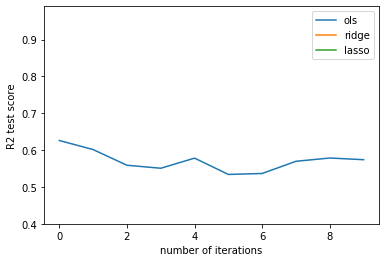

In [39]:
make_models(data, target, num_iter=10, models=['ols', 'lasso', 'ridge'],
               alpha=10, complexity='simple', degree=2)

---

### Feature Selection Run

In [50]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [53]:
data.shape

(5859, 54)

In [51]:
stepwise_selection(data, target, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

Add  beds                           with p-value 0.0
Add  bedrooms                       with p-value 1.91757e-138
Add  room_Private room              with p-value 4.96209e-125
Add  minimum_nights                 with p-value 1.14304e-100
Add  latitude                       with p-value 1.21775e-91
Add  number_of_reviews              with p-value 4.11729e-37
Add  bathrooms                      with p-value 1.11899e-29
Add  extra_people                   with p-value 4.12856e-19
Add  accommodates                   with p-value 1.18912e-18
Drop beds                           with p-value 0.260428


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  longitude                      with p-value 8.24926e-12
Add  review_scores_rating           with p-value 1.02178e-10
Add  prop_Guest suite               with p-value 1.86525e-08
Add  nbrhd_Pacific Heights          with p-value 3.30435e-08
Add  nbrhd_Nob Hill                 with p-value 1.5447e-05
Add  nbrhd_Chinatown                with p-value 1.1252e-05
Add  nbrhd_Noe Valley               with p-value 3.33001e-05
Add  nbrhd_Outer Richmond           with p-value 7.62525e-05
Add  nbrhd_Castro/Upper Market      with p-value 0.000229358
Add  nbrhd_South of Market          with p-value 0.000254826
Add  nbrhd_Outer Sunset             with p-value 0.000168641
Drop longitude                      with p-value 0.138088
Add  host_response_rate             with p-value 0.000401825
Add  prop_House                     with p-value 0.000711608
Add  nbrhd_Inner Richmond           with p-value 0.00111427
Add  nbrhd_Parkside                 with p-value 0.000975954
Add  nbrhd_Excelsior          

['bedrooms',
 'room_Private room',
 'minimum_nights',
 'latitude',
 'number_of_reviews',
 'bathrooms',
 'extra_people',
 'accommodates',
 'review_scores_rating',
 'prop_Guest suite',
 'nbrhd_Pacific Heights',
 'nbrhd_Nob Hill',
 'nbrhd_Chinatown',
 'nbrhd_Noe Valley',
 'nbrhd_Outer Richmond',
 'nbrhd_Castro/Upper Market',
 'nbrhd_South of Market',
 'nbrhd_Outer Sunset',
 'host_response_rate',
 'prop_House',
 'nbrhd_Inner Richmond',
 'nbrhd_Parkside',
 'nbrhd_Excelsior',
 'guests_included',
 'nbrhd_Seacliff',
 'prop_Condominium',
 'nbrhd_Financial District']

In [76]:
data2 = data[['bedrooms',
 'room_Private room',
 'minimum_nights',
 'latitude',
 'number_of_reviews',
 'bathrooms',
 'extra_people',
 'accommodates',
 'review_scores_rating',
 'prop_Guest suite',
 'nbrhd_Pacific Heights',
 'nbrhd_Nob Hill',
 'nbrhd_Chinatown',
 'nbrhd_Noe Valley',
 'nbrhd_Outer Richmond',
 'nbrhd_Castro/Upper Market',
 'nbrhd_South of Market',
 'nbrhd_Outer Sunset',
 'host_response_rate',
 'prop_House',
 'nbrhd_Inner Richmond',
 'nbrhd_Parkside',
 'nbrhd_Excelsior',
 'guests_included',
 'nbrhd_Seacliff',
 'prop_Condominium',
 'nbrhd_Financial District']]

#### Trying out different models with the reduced predictor dataset

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12180.379794169217, tolerance: 9841.950945210156
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11960.118356157094, tolerance: 9566.725960273096
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13020.9237472713, tolerance: 9530.557443268617
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

({'lasso': Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
        normalize=True, positive=False, precompute=False, random_state=None,
        selection='cyclic', tol=0.0001, warm_start=False),
  'ridge': Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
        normalize=True, random_state=None, solver='auto', tol=0.001)},
 {'lasso_train_rmse': 83.48769685803639,
  'lasso_test_rmse': 87.9015223702678,
  'lasso_test_r2': 0.6277471115051148,
  'lasso_train_r2': 0.6576286427382395,
  'ridge_train_rmse': 76.38201039655657,
  'ridge_test_rmse': 94.30375700398784,
  'ridge_test_r2': 0.5715469160704405,
  'ridge_train_r2': 0.7134274201704972})

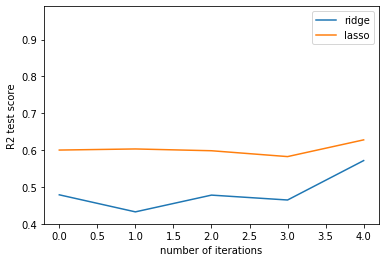

In [62]:
make_models(data2, target, num_iter=5, models=['lasso', 'ridge'],
               alpha=0.01, complexity='poly_intx', degree=3)

---

#### Refactoring the `make_models` function to include `LassoCV`, `RidgeCV`, `ElasticNetCV` instead of using `GridSearchCV` for model selection and hyperparameter tuning. These three functions also seem to be computationally more efficient.

In [ ]:
def make_models(data, target, num_iter=5, models=['ols', 'lasso', 'ridge', 'enet'],
               alpha=[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20], cv_param=[3, 5, 8, 10],
                l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], complexity='simple', degree=3):
    x_axis = np.arange(num_iter)
    ols_test = []
    lasso_test = []
    ridge_test = []
    enet_test = []
    # parameters = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
    sample_models = {}
    model_metrics = {}
    


    for val in cv_param:
        for a in alpha:
            for l1 in l1_ratio:
                for i in range(num_iter):
                    if complexity == 'simple':
                        X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2)
                    elif complexity == 'polynomial':
                        poly = PolynomialFeatures(degree=degree)
                        Xp = poly.fit_transform(data)
                        X_train, X_test, Y_train, Y_test = train_test_split(Xp, target, test_size=0.2)
                    elif complexity == 'poly_intx':
                        poly_intx = PolynomialFeatures(degree=degree, interaction_only=True)
                        Xpn = poly_intx.fit_transform(data)
                        X_train, X_test, Y_train, Y_test = train_test_split(Xpn, target, test_size=0.2)
                    scaler = StandardScaler()
                    scaler.fit(X_train)
                    X_train=scaler.transform(X_train)
                    X_test=scaler.transform(X_test)
                    
                    if 'ols' in models:
                        linreg = LinearRegression()
                        ols_model_tr = linreg.fit(X_train, Y_train)
                        train_pred = ols_model_tr.predict(X_train)
                        test_pred = ols_model_tr.predict(X_test)
                        sample_models['ols'] = ols_model_tr
                        test_score = ols_model_tr.score(X_test, Y_test)
                        ols_test.append(test_score)
                        model_metrics['ols_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
                        model_metrics['ols_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
                        model_metrics['ols_test_r2'] = ols_model_tr.score(X_test, Y_test)
                        model_metrics['ols_train_r2'] = ols_model_tr.score(X_train, Y_train)
                    
                    if 'lasso' in models:
                        lasso = LassoCV(alphas=a, normalize=True, cv=val)
                        lasso_model_tr = lasso.fit(X_train, Y_train)
                        train_pred = lasso_model_tr.predict(X_train)
                        test_pred = lasso_model_tr.predict(X_test)
                        sample_models['lasso'] = lasso_model_tr
                        test_score = lasso_model_tr.score(X_test, Y_test)
                        lasso_test.append(test_score)
                        model_metrics['lasso_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
                        model_metrics['lasso_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
                        model_metrics['lasso_test_r2'] = lasso_model_tr.score(X_test, Y_test)
                        model_metrics['lasso_train_r2'] = lasso_model_tr.score(X_train, Y_train)

                    if 'ridge' in models:
                        ridge = RidgeCV(alphas=a, normalize=True, cv=val)
                        ridge_model_tr = ridge.fit(X_train, Y_train)
                        train_pred = ridge_model_tr.predict(X_train)
                        test_pred = ridge_model_tr.predict(X_test)
                        sample_models['ridge'] = ridge_model_tr
                        test_score = ridge_model_tr.score(X_test, Y_test)
                        ridge_test.append(test_score)
                        model_metrics['ridge_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
                        model_metrics['ridge_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
                        model_metrics['ridge_test_r2'] = ridge_model_tr.score(X_test, Y_test)
                        model_metrics['ridge_train_r2'] = ridge_model_tr.score(X_train, Y_train)

                    if 'enet' in models:
                        enet = ElasticNetCV(alphas=a, l1_ratio = l1, cv=val)
                        enet_model_tr = enet.fit(X_train, Y_train)
                        train_pred = enet_model_tr.predict(X_train)
                        test_pred = enet_model_tr.predict(X_test)
                        sample_models['enet'] = enet_model_tr
                        test_score = enet_model_tr.score(X_test, Y_test)
                        enet_test.append(test_score)
                        model_metrics['enet_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
                        model_metrics['enet_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
                        model_metrics['enet_test_r2'] = enet_model_tr.score(X_test, Y_test)
                        model_metrics['enet_train_r2'] = enet_model_tr.score(X_train, Y_train)
                    i += 1
    
    if 'ols' in models:
        plt.plot(ols_test, label='ols')
    if 'ridge' in models:
        plt.plot(ridge_test, label='ridge')
    if 'lasso' in models:
        plt.plot(lasso_test, label='lasso')
    plt.ylabel('R2 test score')
    plt.xlabel('number of iterations')
    plt.ylim((0.40, 0.99))

    plt.legend()
    
    model_metrics = pd.DataFrame.from_dict(model_metrics)
    
                              
    return sample_models, model_metrics

In [ ]:
make_models(data=data, target=target, models=['ols', 'lasso', 'ridge', 'enet'])

In [73]:
def make_models(data, target, num_iter=5, models=['ols', 'lasso', 'ridge','enet'], complexity='simple', degree=3):
    '''This function takes in the features, target, model, and complexity to return
    r^2 value'''
    x_axis = np.arange(num_iter)
    ols_test = []
    lasso_test = []
    ridge_test = []
    enet_test = []
    cv = [5,8,12,15,20]
    sample_models = {}
    parameters = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
    model_metrics = {}
    for val in cv:
        for i in range(num_iter):
            if complexity == 'simple':
                X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2)
            elif complexity == 'polynomial':
                poly = PolynomialFeatures(degree=degree)
                Xp = poly.fit_transform(data)
                X_train, X_test, Y_train, Y_test = train_test_split(Xp, target, test_size=0.2)
            elif complexity == 'poly_intx':
                poly_intx = PolynomialFeatures(degree=degree, interaction_only=True)
                Xpn = poly_intx.fit_transform(data)
                X_train, X_test, Y_train, Y_test = train_test_split(Xpn, target, test_size=0.2)
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train=scaler.transform(X_train)
            X_test=scaler.transform(X_test)
            if 'ols' in models:
                linreg = LinearRegression()
                ols_model_tr = linreg.fit(X_train, Y_train)
                train_pred = ols_model_tr.predict(X_train)
                test_pred = ols_model_tr.predict(X_test)
                sample_models['ols'] = ols_model_tr
                test_score = ols_model_tr.score(X_test, Y_test)
                ols_test.append(test_score)
                model_metrics['ols_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
                model_metrics['ols_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
                model_metrics['ols_test_r2'] = ols_model_tr.score(X_test, Y_test)
                model_metrics['ols_train_r2'] = ols_model_tr.score(X_train, Y_train)
            if 'lasso' in models:
                #lasso_regressor = GridSearchCV(Lasso(), parameters, scoring='neg_mean_squared_error', cv = 5)
                #lasso_regressor.fit(X_train, Y_train)
                #alpha = list(lasso_regressor.best_params_.values())[0]
                lasso = LassoCV(alphas=parameters, cv = val)
                lasso_model_tr = lasso.fit(X_train, Y_train)
                train_pred = lasso_model_tr.predict(X_train)
                test_pred = lasso_model_tr.predict(X_test)
                sample_models['lasso'] = lasso_model_tr
                test_score = lasso_model_tr.score(X_test, Y_test)
                lasso_test.append(test_score)
                model_metrics['lasso_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
                model_metrics['lasso_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
                model_metrics['lasso_test_r2'] = lasso_model_tr.score(X_test, Y_test)
                model_metrics['lasso_train_r2'] = lasso_model_tr.score(X_train, Y_train)
            if 'ridge' in models:
                #ridge_regressor = GridSearchCV(Ridge(), parameters, scoring='neg_mean_squared_error', cv = 5)
                #ridge_regressor.fit(X_train, Y_train)
                #alpha = list(ridge_regressor.best_params_.values())[0]
                ridge = RidgeCV(alphas=parameters,cv = val)
                ridge_model_tr = ridge.fit(X_train, Y_train)
                train_pred = ridge_model_tr.predict(X_train)
                test_pred = ridge_model_tr.predict(X_test)
                sample_models['ridge'] = ridge_model_tr
                test_score = ridge_model_tr.score(X_test, Y_test)
                ridge_test.append(test_score)
                model_metrics['ridge_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
                model_metrics['ridge_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
                model_metrics['ridge_test_r2'] = ridge_model_tr.score(X_test, Y_test)
                model_metrics['ridge_train_r2'] = ridge_model_tr.score(X_train, Y_train)
            if 'enet' in models:
                enet = ElasticNetCV(alphas=parameters, l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],cv = val)
                enet_model_tr = enet.fit(X_train, Y_train)
                train_pred = enet_model_tr.predict(X_train)
                test_pred = enet_model_tr.predict(X_test)
                sample_models['enet'] = enet_model_tr
                test_score = enet_model_tr.score(X_test, Y_test)
                enet_test.append(test_score)
                model_metrics['enet_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
                model_metrics['enet_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
                model_metrics['enet_test_r2'] = enet_model_tr.score(X_test, Y_test)
                model_metrics['enet_train_r2'] = enet_model_tr.score(X_train, Y_train)
            i += 1
    if 'ols' in models:
        plt.plot(ols_test, label='ols')
    if 'ridge' in models:
        plt.plot(ridge_test, label='ridge')
    if 'lasso' in models:
        plt.plot(lasso_test, label='lasso')
    if 'enet' in models:
        plt.plot(enet_test, label='enet')
    plt.ylabel('R2 test score')
    plt.xlabel('number of iterations')
    plt.ylim((0.40, 0.99))
    plt.legend()
    
    return sample_models, model_metrics

In [79]:
make_models(data2, target, num_iter=5, models=['lasso', 'ridge','enet'], complexity='poly_intx', degree=2)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6511492.691042336, tolerance: 7540.092439850626
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11077582.416930955, tolerance: 7540.092439850626
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12065298.988433141, tolerance: 7540.092439850626
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8292819.673069855, tolerance: 7540.092439850626
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12383903.644567417, tolerance: 7540.092439850626
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not co

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12109002.46650839, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108809.655584915, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5950757.231693488, tolerance: 7540.092439850626
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12109087.236213665, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108829.562612314, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108645.99357751, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108850.484664135, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108670.720705712, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6329861.227544813, tolerance: 7540.092439850626
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108962.300875563, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108800.21331231, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108625.368449735, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108610.481253734, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108441.408682691, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6018106.564468378, tolerance: 7540.092439850626
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108312.175803632, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108148.785019787, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6511492.691042336, tolerance: 7540.092439850626
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108291.48415072, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108153.239059724, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12107990.283828411, tolerance: 7402.676405440002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13374516.97483515, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13374173.618735326, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13373888.721262928, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13307706.857672391, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13384144.787313433, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13375856.154170344, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12759950.08558156, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13321862.92925532, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13375321.51136504, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12607391.666815426, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13281603.003747907, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13375025.640968509, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12379906.503988728, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13213467.73837863, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13374669.316650087, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7152589.401865836, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12209428.231655912, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13168725.45582154, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12570564.667210877, tolerance: 7750.888807040001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7095291.909379191, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11989527.233684918, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7661053.592944447, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11943222.364303518, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13077476.867577683, tolerance: 7675.408626373334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7290103.771770624, tolerance: 7342.94423264
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11161422.476772316, tolerance: 7342.94423264
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11842447.05324566, tolerance: 7342.94423264
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to incre

KeyboardInterrupt: 